In [7]:
ORIG_DATA = '/media/HDD1/data/atari_v2/raw'
DATA_FOLDER = '/media/HDD1/data/atari_v2/cleaned'

In [21]:
import numpy as np
from os import listdir, remove
from os.path import join as pjoin
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import time
import cv2
from util import load_trajectories, get_trajs_stats, agc_to_gym

%matplotlib inline

In [9]:
screens_path = pjoin(DATA_FOLDER, 'screens')
trajs_path = pjoin(DATA_FOLDER, 'trajectories')

Though 'good' trajectories are only ~60% of all the trajectories, they are ~90% of all the frames. So, we just delete the 'zero-score' games and will not lose much. And the data will be cleaner and more usable.

In [10]:
# it's fast just to copy the original data folder like
# $ cp -R atari_170306/ atari_170306_corrected 
# and then run this cell with shutil.rmtree/copytress lines commented
# but if you're not afraid of waiting, just uncomment and run, and wait...

# shutil.rmtree(DATA_FOLDER, ignore_errors=True)
# shutil.copytree(ORIG_DATA, DATA_FOLDER)

# let's remove crazy scores for the first 3 frames
for game in listdir(trajs_path):
    game_dir = pjoin(trajs_path, game)
    for traj in listdir(game_dir):
        curr_traj = []
        
        with open(pjoin(game_dir, traj), 'r') as f:
            lines = f.readlines()
            #we want to replace 0,1,2 frames, hence, lines 2,3,4
            lines[2] = "0,0,0,0,0\n"
            lines[3] = "1,0,0,0,0\n"
            lines[4] = "2,0,0,0,0\n"
            with open(pjoin(game_dir, traj), 'w') as nf:
                nf.writelines(lines)

# remove files with constant crazy scores and all-zero scores
trajectories = {}
files_to_delete = []
for game in listdir(trajs_path):
    trajectories[game] = {}
    game_dir = pjoin(trajs_path, game)
    for traj in listdir(game_dir):
        curr_traj = []
        with open(pjoin(game_dir, traj)) as f:
            for i,line in enumerate(f):
                if i > 1:
                    curr_data = line.rstrip('\n').replace(" ","").split(',')
                    curr_traj.append([int(curr_data[j]) if j != 3 else int(curr_data[j]!='False') for j in range(len(curr_data))])
        # we start checking from 3rd frame since we have already replaced 
        # crazy score for 0,1,2 frames with zeroes.
        # we can avoid this by changing the order of data fix
        # but I chose this variant
        if(len(set([el[2] for el in curr_traj[3:]])) == 1):
            files_to_delete.append(pjoin(game, traj.split('.txt')[0]))
        else:
            trajectories[game][int(traj.split('.txt')[0])] = curr_traj
    
for f in files_to_delete:
    remove(pjoin(trajs_path, f + '.txt'))
    #remove their screnshots folders also
    shutil.rmtree(pjoin(screens_path, f), ignore_errors=True)

print("Deleted files: ", len(files_to_delete))

Deleted files:  3030


In [22]:
def adjust_states(screens_path):
    for g in listdir(screens_path):
        g_dir = pjoin(screens_path,g)
        for traj in listdir(g_dir):
            t_dir = pjoin(g_dir, traj)
            for s in listdir(t_dir):
                pic_name = pjoin(t_dir, s)
                pic = cv2.imread(pic_name)
                newpic = agc_to_gym(g,pic)
                cv2.imwrite(pic_name, newpic)

# uncomment to adjust states
# THIS WILL OVERWRITE YOUR SCRENSHOT DATA!!!
start_time = time.clock()
adjust_states(screens_path)
print("State adjustment took %.3f minutes." % ((time.clock() - start_time)/60))

State adjustment took 320.397 minutes.


In [11]:
# reload the data after correction
trajectories = load_trajectories(pjoin(ORIG_DATA, 'trajectories'))

scores, games, _, _, _, _  = get_trajs_stats(trajectories, remove_all_zeroes=False)
print("Total trajectories: %d." % (sum([games[g] for g in games])))
print("Total frames:       %s." % "{:,}".format((sum([sum([len(s) for s in scores[g]]) for g in scores]))))

#get statistics for 'good' trajs (which have positive final score)
g_scores, g_games, _, _, _, _ = get_trajs_stats(trajectories, remove_all_zeroes=True)
print("Total \'good\' trajectories: %d." % (sum([g_games[g] for g in g_games])))
print("Total \'good\' frames:       %s." % "{:,}".format((sum([sum([len(s) for s in g_scores[g]]) for g in g_scores]))))

Total trajectories: 7432.
Total frames:       22,365,791.
Total 'good' trajectories: 4457.
Total 'good' frames:       19,758,805.


#### The Atari Grand Challenge screenshots and gym are a little bit different

To make them compatible, we do some adjustments now and we also need to do them for gym data during using the environment

In [16]:
def get_scores(bottom_frame_limit=None, upper_frame_limit=None):
    scores = {}
    total_traj = 0
    for g in trajectories:
        scores[g] = []
        total_traj+=len(trajectories[g].keys())
        for t in trajectories[g]:
            for i in range(bottom_frame_limit if bottom_frame_limit else 0, upper_frame_limit if upper_frame_limit else len(trajectories[g][t])):
                if i < 0 or (upper_frame_limit and upper_frame_limit >= len(trajectories[g][t])):
                    break
                scores[g].append(trajectories[g][t][i][2])
    return scores, total_traj

# #reload data again
trajectories = load_trajectories(pjoin(DATA_FOLDER, 'trajectories'))
scores, total_traj = get_scores()
print("Total trajectories: %d." % (total_traj))
print("Total frames:       %s." % "{:,}".format((sum([len(scores[g]) for g in scores]))))

Total trajectories: 4402.
Total frames:       19,735,377.


The scores do not look so strange anymore. And having some prior information about the game, we can say if it's okay or not. E.g. in *spaceinvaders* or *mspacman* the reward flow is continious and we can see this on plot. In opposite, the *Montezuma's revenge* gives the player a large reward for some achievements like collecting the coins or getting keys. And the score plot is also quite peaky. *qbert* case is also peaky since the player gets a reward for each level completion (so, each peak in plot is the start of the new level).

### Per game score distribution (for all the frames)

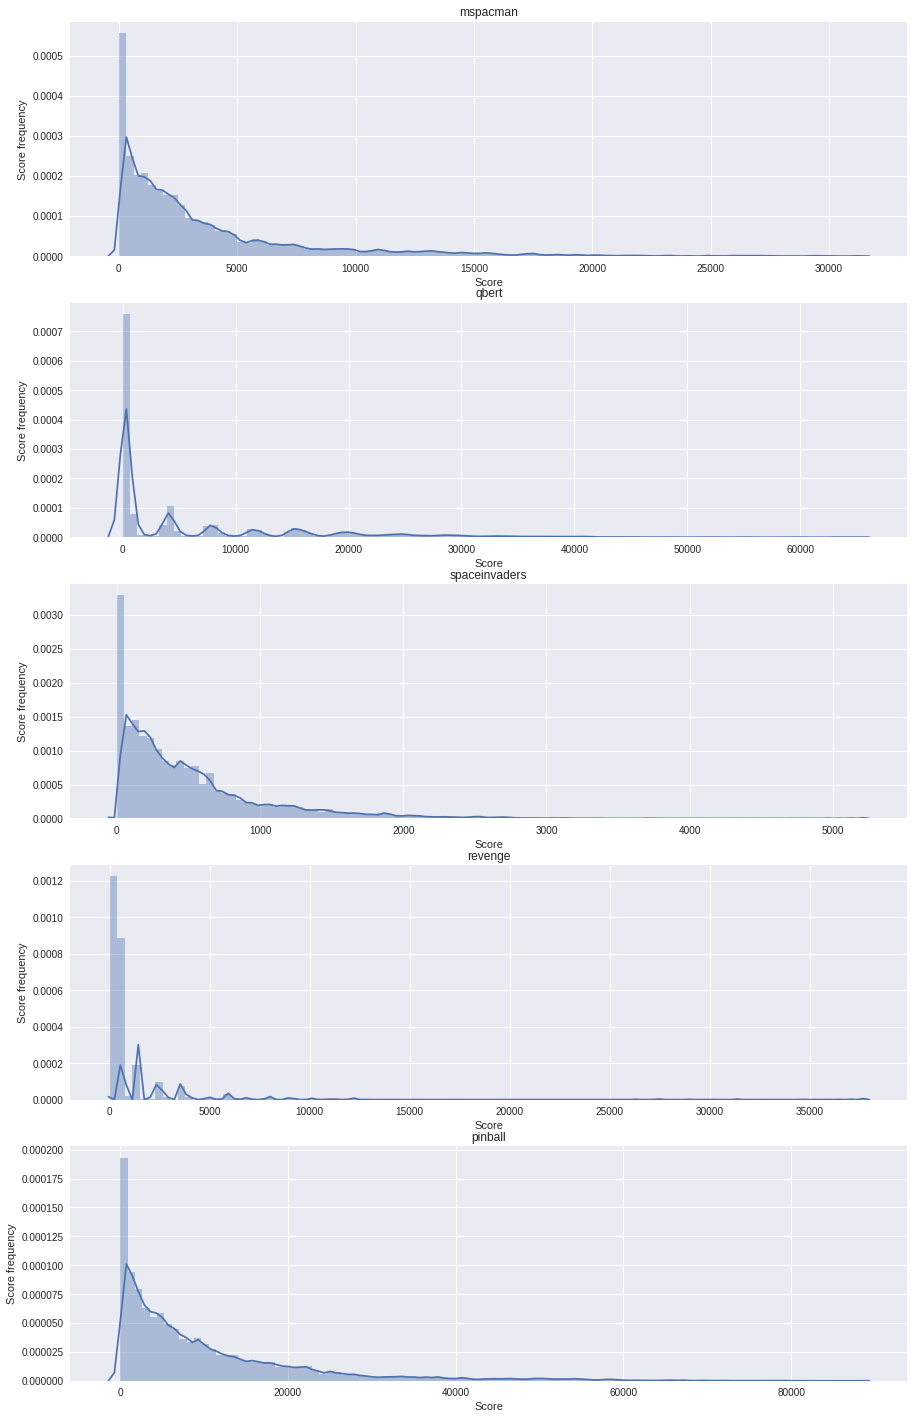

In [19]:
f, axes = plt.subplots(5, figsize=(15,25))
for i,g in enumerate(scores):
    cax = axes[i]
    cax.set_title(g)
    cax.set_xlabel('Score')
    cax.set_ylabel('Score frequency')
    sns.distplot([el for el in scores[g]], bins = 100, ax=cax)

In [17]:
def get_reward(bottom_frame_limit=None, upper_frame_limit=None):
    scores = {}
    total_traj = 0
    for g in trajectories:
        scores[g] = []
        total_traj+=len(trajectories[g].keys())
        for t in trajectories[g]:
            for i in range(bottom_frame_limit if bottom_frame_limit else 0, upper_frame_limit if upper_frame_limit else len(trajectories[g][t])):
                scores[g].append(trajectories[g][t][i][1])
    return scores

def crazy_check(game):
    res = []
    res.append(len(set([el for el in get_reward(5,10)[game] if el < 0])))
    res.append(len(set([el for el in get_reward(3,5)[game] if el < 0])))
    res.append(len(set([el for el in get_reward(2,3)[game] if el < 0])))
    res.append(len(set([el for el in get_reward(1,2)[game] if el < 0])))
    
    return res

No more crazy negative reward.

In [18]:
for g in trajectories:
    print("%15s negative reward seen %d times." %(g, len([el for el in get_reward()[g] if el < 0])))

       mspacman negative reward seen 0 times.
        pinball negative reward seen 0 times.
        revenge negative reward seen 0 times.
  spaceinvaders negative reward seen 0 times.
          qbert negative reward seen 0 times.
